**CUSTOMERGUARD360**

In [ ]:
!pip install xgboost shap imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
import joblib

In [ ]:
from google.colab import files
uploded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.xls to WA_Fn-UseC_-Telco-Customer-Churn.xls


In [ ]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.xls")
df.columns = df.columns.str.strip()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
print("Shape after cleaning:", df.shape)
df.info()

Shape after cleaning: (7032, 21)
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilli

In [ ]:
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])
df['Churn'].value_counts()

,count
Churn,
0,5163
1,1869


In [ ]:
df.drop('customerID', axis=1, inplace=True)
# One-hot encode
cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Scale numeric features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Final check
print("Final feature set shape:", df.shape)
df.head()


Final feature set shape: (7032, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.280248,-1.161694,-0.994194,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,0.064303,-0.260878,-0.173740,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,-1.239504,-0.363923,-0.959649,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,0.512486,-0.747850,-0.195248,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,-1.239504,0.196178,-0.940457,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# To Balance the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After  SMOTE:", y_train_res.value_counts().to_dict())

Before SMOTE: {0: 4130, 1: 1495}
After  SMOTE: {0: 4130, 1: 4130}


In [ ]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_res, y_train_res)

print("🔍 Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:54:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


 Accuracy: 0.7569296375266524
 ROC AUC Score: 0.8128342245989305

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.83      1033
           1       0.54      0.65      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.78      0.76      0.76      1407



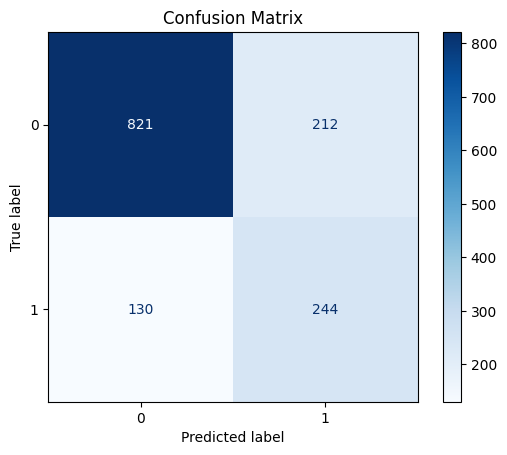

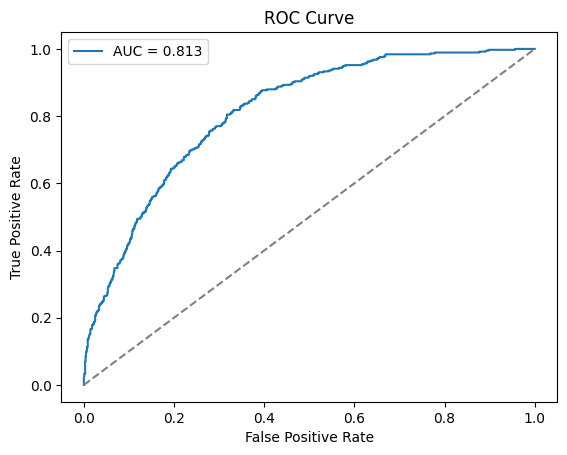

In [ ]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]
print(" Accuracy:", accuracy_score(y_test, y_pred))
print(" ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
#Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
#ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


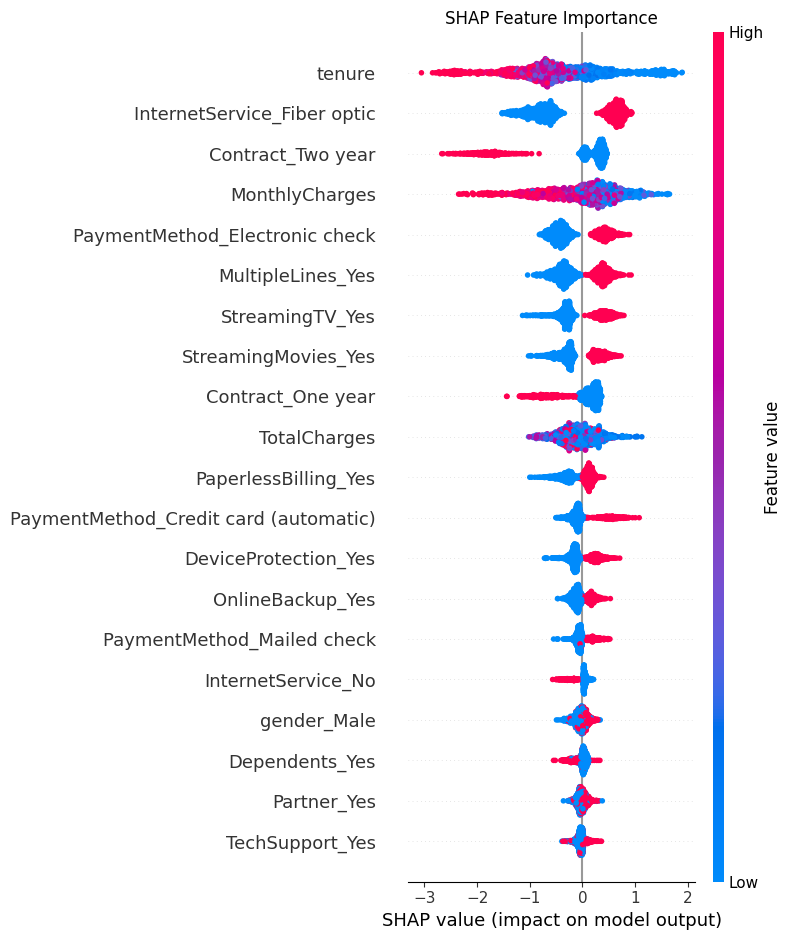

In [ ]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
#plot
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
#predict for a new customer
new_customer = X_test.iloc[0:1]
pred = best_model.predict(new_customer)[0]
prob = best_model.predict_proba(new_customer)[0,1]

print(f"Prediction: {'Churn' if pred==1 else 'Stay'}  |  Probability of churn: {prob:.2f}")


Prediction: Stay  |  Probability of churn: 0.00


In [ ]:
joblib.dump(best_model, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_train.columns.tolist(), 'feature_list.pkl')
#Download
files.download('churn_model.pkl')
files.download('scaler.pkl')
files.download('feature_list.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>